# **Actividad 3 | Aprendizaje supervisado y no supervisado**

**Nombre: Luis Carlos Alberto Espinosa Alvarado   
Matricula: A00816016**

##   **Introducción teorica**

✅ **Aprendizaje Supervisado**

El aprendizaje supervisado es una técnica de machine learning en la que el modelo aprende a partir de un conjunto de datos etiquetados. Esto significa que para cada entrada, se conoce el resultado deseado (la etiqueta), y el algoritmo aprende a predecir esas salidas.

Objetivo: Predecir una variable de salida (target) basada en variables de entrada (features).

📌 Algoritmos representativos:
1. Regresión lineal
2. Regresión logística
3. Máquinas de vectores de soporte (SVM)
4. Árboles de decisión
5. Random Forest
6. Redes neuronales

✅ Algoritmos disponibles en PySpark:
PySpark (a través de pyspark.ml) ofrece:

1. LinearRegression
2. LogisticRegression
3. DecisionTreeClassifier y DecisionTreeRegressor
4. RandomForestClassifier y RandomForestRegressor
5. GBTClassifier y GBTRegressor (Gradient Boosted Trees)
6. NaiveBayes
7. MultilayerPerceptronClassifier (Redes neuronales)

🔶 **Aprendizaje No Supervisado**

El aprendizaje no supervisado se utiliza cuando no hay etiquetas en los datos. El objetivo principal es encontrar patrones, agrupamientos o estructuras ocultas dentro del conjunto de datos.

Objetivo: Explorar la estructura interna de los datos sin conocer las salidas esperadas.

📌 Algoritmos representativos:
1. K-Means
2. DBSCAN
3. Hierarchical clustering
4. Reducción de dimensionalidad (PCA, t-SNE)
5. Reglas de asociación (Apriori, FP-Growth)

🔶 Algoritmos disponibles en PySpark:
PySpark proporciona:

1. KMeans (clustering de k-medias)
2. BisectingKMeans (clustering jerárquico aproximado)
3. GaussianMixture (modelado de mezclas gaussianas)
4. LDA (Latent Dirichlet Allocation para modelado de temas)
5. PCA (reducción de dimensionalidad)
6. FP-Growth (reglas de asociación)

##    **Selección de los datos**

In [ ]:
!pip install pyspark
!pip install findspark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import findspark
import pandas as pd
findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("local[*]").getOrCreate()
# spark.conf.set("sparl.sql.repl.eagerEval.enabled", True)
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql import SparkSession

from pyspark.sql.functions import col, hour, when, unix_timestamp, round as spark_round
from pyspark.sql.types import IntegerType
import numpy as np

spark = SparkSession.builder \
    .appName("YellowTripDataAnalysis") \
    .master("local[*]") \
    .getOrCreate()

spark

In [ ]:
from google.colab import drive # necesario agregar para cargar datos en Google Colab
drive.mount('/content/drive')

# df = spark.read.option("header", True).option("inferSchema", True).csv("../data/yellow_tripdata/yellow_tripdata_2015-01.csv")
df = spark.read.csv(r'/content/drive/MyDrive/Colab Notebooks/MNA/TC4034 - Analisis de grandes volumenes de datos/Actividad 3/yellow_tripdata_2015-01.csv', header=True, inferSchema=True)

Mounted at /content/drive


In [ ]:
num_rows = df.count()
num_cols = len(df.columns)
print(f"Number of registros: {num_rows}")
print(f"Number of columnas: {num_cols}")

print('Esquema de dataframe:')
df.printSchema()
print('Primeras 5 filas del dataframe:')
df.show(5)

Number of registros: 12748986
Number of columnas: 19
Esquema de dataframe:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

Primeras 5 filas del dataframe:
+--------+

In [ ]:
print('Numero de nulos:')
df.select([
    count(when(col(c).isNull() | (col(c).cast("string") == "NaN"), c)).alias(c)
    for c in df.columns
]).show()

Numero de nulos:
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RateCodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       0|                   0|                    0|              0|            0|               0|              0|         0|                

In [ ]:
print('Estadísticas del dataframe:')
df.describe().show()

Estadísticas del dataframe:
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+---------------------+------------------+
|summary|          VendorID|   passenger_count|     trip_distance|   pickup_longitude|   pickup_latitude|        RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|           mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------

### De acuerdo a la actividad anterior, donde se obtuvieron particiones de la base de datos global que cumplen con los criterios de las variables de caracterización identificadas, se propusieron las siguientes tecnicas de muestreo:


*   Combinación: ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 1 / proporción: 0.1753

  Técnica recomendada: Muestreo aleatorio simple

*   Combinación: ((0.0, 10.0), (0.0, 3.0), (1.0, 6.0), (0.0, 2.0)) / iteración: 3 / proporción: 0.1786

  Técnica recomendada: Muestreo estratificado por payment_type

*   Combinación: ((10.0, 20.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0)) / iteración: 13 / proporción: 0.2025

  Técnica recomendada: Muestreo estratificado por passenger_count

De las cuales se elige la primera.

### **Combinación: ((0.0, 10.0), (0.0, 3.0), (0.0, 1.0), (0.0, 2.0))**

(2234293, 19)


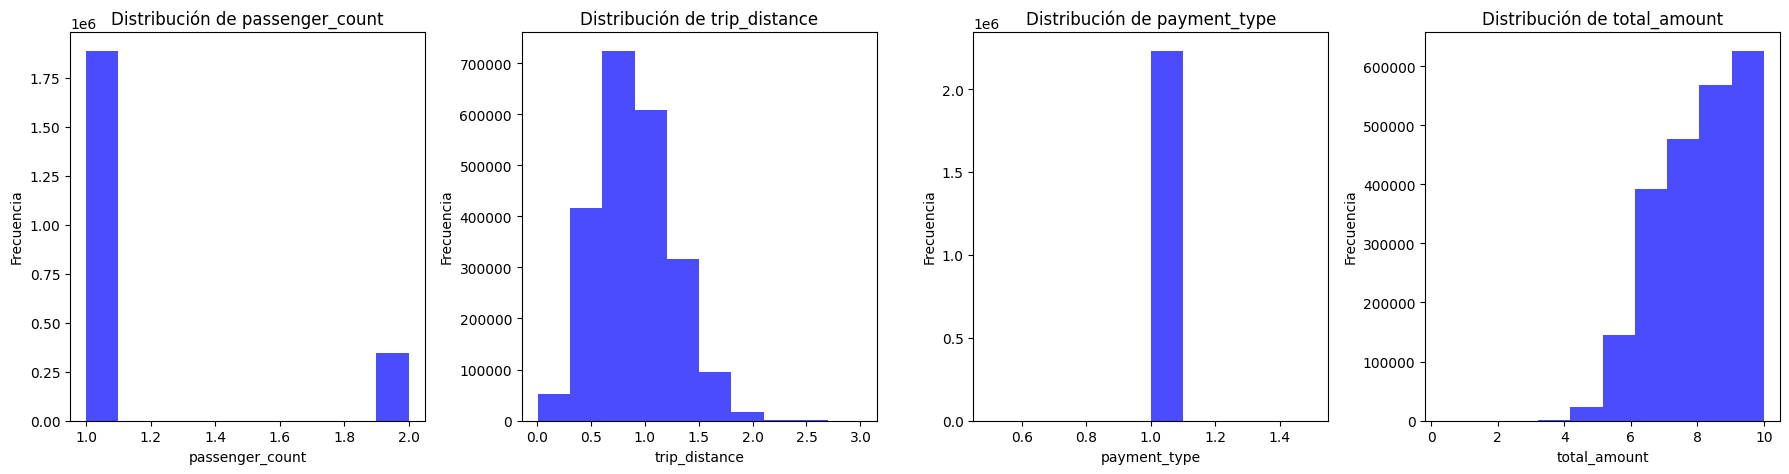

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt


# Definir los rangos de la combinación
total_amount_range = (0.0, 10.0)
trip_distance_range = (0.0, 3.0)
payment_type_range = (0.0, 1.0)
passenger_count_range = (0.0, 2.0)

# Filtrar el DataFrame según la combinación
filtered_df = df.filter(
    (col("total_amount") > total_amount_range[0]) & (col("total_amount") <= total_amount_range[1]) &
    (col("trip_distance") > trip_distance_range[0]) & (col("trip_distance") <= trip_distance_range[1]) &
    (col("payment_type") > payment_type_range[0]) & (col("payment_type") <= payment_type_range[1]) &
    (col("passenger_count") > passenger_count_range[0]) & (col("passenger_count") <= passenger_count_range[1])
)


filtered_df_pd=filtered_df.toPandas()

print(filtered_df_pd.shape)

# Columnas a graficar
cols = ['passenger_count', 'trip_distance', 'payment_type', 'total_amount']

# Crear una figura con subplots en una matriz de 4x1
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 5))

# Iterar sobre las columnas y los ejes para crear los gráficos
for i, col in enumerate(cols):
    axes[i].hist(filtered_df_pd[col], bins=10, color='blue', alpha=0.7)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

# Ajustar el espacio entre los subplots
plt.tight_layout()

**Técnica recomendada:** Muestreo aleatorio simple

**Justificación técnica:**
Esta partición es altamente homogénea. Las gráficas muestran que:
* Las variables no presentan subgrupos internos claros.
* No hay clases ocultas ni agrupaciones adicionales dentro del subconjunto.
* El 100% de los registros tienen el mismo tipo de pago (payment_type = 1), lo que elimina la necesidad de estratificar por ese campo.
* Las pocas observaciones en passenger_count = 2 son insuficientes para justificar un estrato separado.

Aplicar un muestreo aleatorio simple sin reemplazo permite seleccionar una muestra representativa sin introducir sesgos ni sobre-representar ningún subgrupo, porque prácticamente no hay subgrupos que representar.

In [ ]:
filtered_df_pd.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,2.234293e+06,2234293,2234293,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2234293.0,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06,2.234293e+06
mean,1.463343e+00,2015-01-16 18:57:42.562348544,2015-01-16 19:04:09.037218048,1.154512e+00,9.249052e-01,-7.255424e+01,3.996723e+01,1.001980e+00,-7.270023e+01,4.004810e+01,1.0,5.762142e+00,2.762701e-01,4.999002e-01,1.230299e+00,5.076774e-05,2.837659e-01,8.068063e+00
min,1.000000e+00,2015-01-01 00:00:08,2015-01-01 00:02:24,1.000000e+00,1.000000e-02,-8.745187e+01,0.000000e+00,1.000000e+00,-8.026555e+01,-9.029157e+00,1.0,-3.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e-01
25%,1.000000e+00,2015-01-09 15:30:52,2015-01-09 15:37:33,1.000000e+00,7.000000e-01,-7.399203e+01,4.073755e+01,1.000000e+00,-7.399220e+01,4.073761e+01,1.0,5.000000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,7.050000e+00
50%,1.000000e+00,2015-01-16 15:26:43,2015-01-16 15:33:33,1.000000e+00,9.000000e-01,-7.398222e+01,4.075251e+01,1.000000e+00,-7.398186e+01,4.075254e+01,1.0,6.000000e+00,0.000000e+00,5.000000e-01,1.200000e+00,0.000000e+00,3.000000e-01,8.160000e+00
75%,2.000000e+00,2015-01-23 21:12:05,2015-01-23 21:17:52,1.000000e+00,1.160000e+00,-7.396939e+01,4.076707e+01,1.000000e+00,-7.396949e+01,4.076788e+01,1.0,6.500000e+00,5.000000e-01,5.000000e-01,1.500000e+00,0.000000e+00,3.000000e-01,9.200000e+00
max,2.000000e+00,2015-01-31 23:59:59,2016-02-02 12:43:54,2.000000e+00,3.000000e+00,0.000000e+00,5.738552e+01,9.900000e+01,8.527402e+01,5.747092e+01,1.0,1.000000e+01,2.000000e+00,5.000000e-01,1.000000e+01,6.700000e+00,3.000000e-01,1.000000e+01
std,4.986545e-01,NaN,NaN,3.614393e-01,3.448460e-01,1.017398e+01,5.604568e+00,3.953193e-01,9.648649e+00,5.314951e+00,0.0,1.147174e+00,3.512096e-01,7.063568e-03,4.416986e-01,1.146356e-02,6.787263e-02,1.291084e+00


In [ ]:
filtered_df.printSchema()
filtered_df.describe().show()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+-------+------------------+-------------------+------------------+------------------+------------------+------------

In [ ]:
print("Número de registros: " + str(filtered_df.count()))
print("Número de columnas: " + str(len(filtered_df.columns)))

Número de registros: 2234293
Número de columnas: 19


# Preparación de los datos

In [ ]:
# Limpieza básica de datos
df_clean= filtered_df.drop("store_and_fwd_flag")

#Se eliminan registros con valores nulos
df_clean = filtered_df.dropna()

#Se eliminan registros duplicados
df_clean= filtered_df.dropDuplicates()

df_clean.explain()
df_clean.show(5)

print("Número de registros: " + str(df_clean.count()))
print("Número de columnas: " + str(len(df_clean.columns)))

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- HashAggregate(keys=[improvement_surcharge#34, tpep_dropoff_datetime#19, trip_distance#21, dropoff_longitude#26, RateCodeID#24, pickup_latitude#23, tolls_amount#33, VendorID#17, tip_amount#32, payment_type#28, fare_amount#29, pickup_longitude#22, passenger_count#20, store_and_fwd_flag#25, extra#30, total_amount#35, tpep_pickup_datetime#18, dropoff_latitude#27, mta_tax#31], functions=[])
   +- Exchange hashpartitioning(improvement_surcharge#34, tpep_dropoff_datetime#19, trip_distance#21, dropoff_longitude#26, RateCodeID#24, pickup_latitude#23, tolls_amount#33, VendorID#17, tip_amount#32, payment_type#28, fare_amount#29, pickup_longitude#22, passenger_count#20, store_and_fwd_flag#25, extra#30, total_amount#35, tpep_pickup_datetime#18, dropoff_latitude#27, mta_tax#31, 200), ENSURE_REQUIREMENTS, [plan_id=417]
      +- HashAggregate(keys=[knownfloatingpointnormalized(normalizenanandzero(improvement_surcharge#34)) AS improvement_surch

# Preparación del conjunto de entrenamiento y prueba

In [ ]:
# Particionamiento típico
# Se define el valor por default del número de ejecutores
spark.conf.set("spark.sql.shuffle.partitions", "200")
train_data,test_data = df_clean.randomSplit([0.8,0.2], seed = 42)
print(f"""Existen {train_data.count()} instancias en el conjunto train, y {test_data.count()} en el conjunto test""")

Existen 1788004 instancias en el conjunto train, y 446289 en el conjunto test


In [ ]:
train_data.explain()
test_data.explain()

== Physical Plan ==
AdaptiveSparkPlan isFinalPlan=false
+- Sample 0.0, 0.8, false, 42
   +- Sort [VendorID#17 ASC NULLS FIRST, tpep_pickup_datetime#18 ASC NULLS FIRST, tpep_dropoff_datetime#19 ASC NULLS FIRST, passenger_count#20 ASC NULLS FIRST, trip_distance#21 ASC NULLS FIRST, pickup_longitude#22 ASC NULLS FIRST, pickup_latitude#23 ASC NULLS FIRST, RateCodeID#24 ASC NULLS FIRST, store_and_fwd_flag#25 ASC NULLS FIRST, dropoff_longitude#26 ASC NULLS FIRST, dropoff_latitude#27 ASC NULLS FIRST, payment_type#28 ASC NULLS FIRST, fare_amount#29 ASC NULLS FIRST, extra#30 ASC NULLS FIRST, mta_tax#31 ASC NULLS FIRST, tip_amount#32 ASC NULLS FIRST, tolls_amount#33 ASC NULLS FIRST, improvement_surcharge#34 ASC NULLS FIRST, total_amount#35 ASC NULLS FIRST], false, 0
      +- HashAggregate(keys=[improvement_surcharge#34, tpep_dropoff_datetime#19, trip_distance#21, dropoff_longitude#26, RateCodeID#24, pickup_latitude#23, tolls_amount#33, VendorID#17, tip_amount#32, payment_type#28, fare_amount#29, 

In [ ]:
train_data.show(5)
test_data.show(5)

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2015-01-01 00:00:52|  2015-01-01 00:04:47|              1|          0.4|-73.99990844726562|40.732852935791016|         1|    

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['passenger_count', 'trip_distance', 'payment_type', 'fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount'], outputCol = 'Attributes')
output_train = assembler.transform(train_data)
output_test = assembler.transform(test_data)

output_train.show(5)
output_test.show(5)

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|          Attributes|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1| 2015-01-01 00:00:52|  2015-01-01 00:04:47|              1|    

# Construcción de modelo de aprendizaje supervisado


In [28]:
# Se manda a entrenar con un modelo de regresion Lineal
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'Attributes', labelCol = 'total_amount', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(output_train)


In [29]:
# Se Imprimen los valores de los coeficientes
print ("The coefficient of the model is : ", lr_model.coefficients)
print ("The Intercept of the model is : ", lr_model.intercept)

The coefficient of the model is :  [0.0,0.0,0.0,0.07176324241990555,0.0,0.0,0.0,0.0,0.0,0.7399143393761345]
The Intercept of the model is :  1.6847999513363057


In [30]:
# Se aplica el modelo al conjunto test
Pred_lr = lr_model.evaluate(output_test)

In [31]:
# Evaluación del modelo
from pyspark.ml.evaluation import RegressionEvaluator

#Root Mean Square Error
eval_lr = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction", metricName="rmse")
rmse_lr = eval_lr.evaluate(Pred_lr.predictions)
print("RMSE: %.3f" % rmse_lr)

# Mean Square Error
mse = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error
mae = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination
r2 = eval_lr.evaluate(Pred_lr.predictions, {eval_lr.metricName: "r2"})
print("r2: %.3f" %r2)

RMSE: 0.264
MSE: 0.070
MAE: 0.220
r2: 0.958


In [32]:
# salvando el modelo lr_model y si existe sobreescribirlo
lr_model.save("/content/drive/MyDrive/Colab Notebooks/MNA/TC4034 - Analisis de grandes volumenes de datos/Actividad 3/lr_model")
# Leer el modelo del directorio
from pyspark.ml.regression import LinearRegressionModel
lr_model_loaded = LinearRegressionModel.load("/content/drive/MyDrive/Colab Notebooks/MNA/TC4034 - Analisis de grandes volumenes de datos/Actividad 3/lr_model")

# Construcción de modelo de aprendizaje no supervisado

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Entrenar modelo de KMeans
kmeans = KMeans(featuresCol="Attributes", k=3, seed=1)
kmeans_model = kmeans.fit(output_train)

In [35]:
# Hacer predicciones
predictions = kmeans_model.transform(output_train)

# Evaluar con Silhouette Score (medida estándar en clustering)
evaluator = ClusteringEvaluator(featuresCol="Attributes", predictionCol="prediction", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette:.3f}")

Silhouette Score: 0.553


In [36]:
# Obtener los centros de clúster
centers = kmeans_model.clusterCenters()
print("Centros de los clústeres:")
for idx, center in enumerate(centers):
    print(f"Clúster {idx}: {center}")

Centros de los clústeres:
Clúster 0: [1.14905405e+00 5.84783472e-01 1.00000000e+00 4.34491204e+00
 2.25800825e-01 4.99886623e-01 9.82604670e-01 5.01638615e-05
 2.82471741e-01 6.35258304e+00]
Clúster 1: [1.15690268e+00 1.20850183e+00 1.00000000e+00 6.93671007e+00
 2.64212735e-01 4.99893182e-01 1.37754166e+00 3.49348871e-05
 2.84578545e-01 9.37784020e+00]
Clúster 2: [1.15596129e+00 8.86662935e-01 1.00000000e+00 5.60916511e+00
 3.23651546e-01 4.99919391e-01 1.25973538e+00 7.76388012e-05
 2.83830649e-01 7.99192389e+00]


In [43]:
# salvando el modelo kmeans_model y si existe sobreescribirlo
kmeans_model.write().overwrite().save("/content/drive/MyDrive/Colab Notebooks/MNA/TC4034 - Analisis de grandes volumenes de datos/Actividad 3/kmeans_model")
# Leer el modelo del directorio
from pyspark.ml.clustering import KMeansModel
kmeans_model_loaded = KMeansModel.load("/content/drive/MyDrive/Colab Notebooks/MNA/TC4034 - Analisis de grandes volumenes de datos/Actividad 3/kmeans_model")

# Conclusiones

El modelo de regresión lineal entrenado muestra un muy buen desempeño predictivo según las métricas obtenidas:

- RMSE (Root Mean Square Error) = 0.264
Este valor indica que, en promedio, las predicciones del modelo se desvían en ±0.264 unidades respecto al valor real. Es un error bajo, lo que sugiere buena precisión general.

- MSE (Mean Squared Error) = 0.070
Confirma que el error cuadrático medio es pequeño. Como MSE penaliza los errores grandes, este valor también respalda la calidad del modelo.

- MAE (Mean Absolute Error) = 0.220
Refleja que, en promedio, la desviación absoluta entre predicciones y valores reales es de solo 0.220 unidades, lo cual es muy aceptable.

- R² (Coeficiente de determinación) = 0.958
Este valor indica que el modelo explica el 95.8% de la variabilidad de la variable dependiente. Es un excelente ajuste, ya que valores cercanos a 1 indican una fuerte relación entre variables.

En el modelo de KMeans, el valor de Silhouette Score obtenido es 0.553, lo cual indica un buen nivel de separación entre los clústeres generados por el modelo.

¿Qué significa este valor?
El Silhouette Score varía entre -1 y 1:

- Cercano a 1: Excelente agrupamiento, los puntos están bien asignados a sus clústeres.

- Cerca de 0: Los puntos están en el límite entre clústeres (no muy bien definidos).

- Menor a 0: Los puntos están mal agrupados.

Un 0.553 indica que los datos están moderadamente bien agrupados, con una buena cohesión interna (compactación de clústeres) y separación entre grupos.

Esto sugiere que:

- El número de clústeres (k) elegido es razonable.

- Los atributos usados en features capturan adecuadamente las diferencias entre grupos.